In [5]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import datetime as dtm
import vel_tools as vt

from salishsea_tools import nc_tools, viz_tools

%matplotlib inline
mpl.rcParams.update({'font.size': 12})
mpl.rcParams["axes.formatter.useoffset"] = False

In [6]:
def format_plot(ax, xlim=None, ylim=None, xticks=None, yticks=None, xlabel=None, ylabel=None, title=None):
    '''Simplifies formatting code for plots
    '''
    
    if xlim   is not None: ax.set_xlim(xlim)
    if ylim   is not None: ax.set_ylim(ylim)
    if xticks is not None: ax.set_xticks(xticks)
    if yticks is not None: ax.set_yticks(yticks)
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if title  is not None: ax.set_title(title)

In [7]:
def make_plots(datein, t=[0], zlevel=[0], ylocn=455, section_slice=np.arange(238, 318),
               map_bounds=np.array([-124, -123, 48.5, 49.7])):
    '''Plot nowcast and nowcast-green velocity fields
    '''
    
    # Version
    version = 3.6
    
    # ----- LOAD WIND FORCING -----
    wind_OP, wind_RS = vt.load_wind(datein)                                                    ### VT.LOAD_WIND
    lat_wind = wind_OP.variables['nav_lat']
    lon_wind = wind_OP.variables['nav_lon']
    u_wind   = wind_OP.variables['u_wind']
    v_wind   = wind_OP.variables['v_wind']
    SLP      = wind_OP.variables['atmpres']
    
    # ----- LOAD NEMO RESULTS -----
    u_vel, v_vel, w_vel, tracers = vt.load_NEMO_OP(datein, version=version, avg='h')           ### VT.LOAD_NEMO_OP
    PA, PA_time = vt.load_NEMO_stations(datein, version=version, station_name='PointAtkinson') ### VT.LOAD_NEMO_STATIONS
    VI, VI_time = vt.load_NEMO_stations(datein, version=version, station_name='Victoria')      ### VT.LOAD_NEMO_STATIONS
    
    # ----- DEFINE SUBFIELDS -----
    ugrid     = u_vel.variables['vozocrtx']
    vgrid     = v_vel.variables['vomecrty']
    zlevels   = u_vel.variables['depthu']
    lats      = u_vel.variables['nav_lat']
    lons      = u_vel.variables['nav_lon']
    tindex    = u_vel.variables['time_counter']
    timestamp = nc_tools.timestamp(u_vel, t)
    
    # ----- MAKE PLOTS -----
    fig, ax = plt.subplots(1, 6, figsize=(15, 20))
    gs = mpl.gridspec.GridSpec(4, 3, width_ratios=[2.3, 1, 1], height_ratios=[1, 1, 1.5, .45])
    ax[0] = plt.subplot(gs[:2, 0])
    ax[1] = plt.subplot(gs[ 0, 1:])
    ax[2] = plt.subplot(gs[ 1, 1:])
    ax[3] = plt.subplot(gs[ 2:, 0])
    ax[4] = plt.subplot(gs[ 2, 1])
    ax[5] = plt.subplot(gs[ 2, 2])
    
    # ----- PLOT SURFACE CURRENTS -----
    Q1 = vt.plot_horz_currents(ax[0], lons, lats, ugrid, vgrid, t=t, zlevel=zlevel)           ### VT.PLOT_HORZ_CURRENTS
    Q2 = vt.plot_wind(ax[0], lon_wind, lat_wind, u_wind, v_wind, t=t)                         ### VT.PLOT_WIND
    ax[0].add_patch(mpl.patches.Rectangle((-124, 49.53), 0.2, 0.17, facecolor='white'))
    plt.quiverkey(Q1, 0.1, 0.93, 1, '1 m/s')
    plt.quiverkey(Q2, 0.1, 0.87, 1, '1 m/s')
    ax[0].plot(lons[ylocn, section_slice], lats[ylocn, section_slice],
                  linestyle='solid', linewidth=3, color='black', label='Section Line')
    ax[0].plot(lons[416, 283], lats[416, 283], 'ko', markersize=8, label='ONC East')
    ax[0].plot(lons[424, 266], lats[424, 266], 'ko', markersize=8, label='ONC Central')
    ax[0].plot(-123.27, 49.33, 'ko', markersize=8, label='Point Atkinson')
    format_plot(ax[0], xlim  = map_bounds[0:2],
                       ylim  = map_bounds[2:4],
                       title = 'NEMO {:.1f} surface currents, GEM HRDPS 10m winds'.format(version))
    
    # ----- PLOT ALONGSHORE CURRENTS -----
    mesh = vt.plot_cross_section(ax[3], lons, vgrid, zlevels, ylocn, section_slice,           ### VT.PLOT_CROSS_SECTION
                                 t=t, crange=np.array([-.5, .5]))
    ax[3].plot(np.array([lons[416, 283], lons[416, 283]]), np.array([0, 450]),
                  linestyle='solid', linewidth=3, color='black', label='ONC East')
    ax[3].plot(np.array([lons[424, 266], lons[424, 266]]), np.array([0, 450]),
                  linestyle='solid', linewidth=3, color='black', label='ONC Central')
    cbar = fig.colorbar(mesh, ax=ax[3], orientation='horizontal')
    cbar.set_ticks(np.arange(-.5, .501, .1))
    cbar.set_label('Alongstrait Velocity [m/s]')
    format_plot(ax[3], xlim   = [-123.55, -123.25],
                       ylim   = [400, 0],
                       xticks = np.arange(-123.5, -123.3, 0.1),
                       ylabel = 'Depth [m]')
        
    # Plot Point Atkinson SSH
    ax[1].plot(PA_time, PA.variables['sossheig'][:, 0, 0], 'k-')
    ax[1].plot(PA_time[t[0]*4], PA.variables['sossheig'][t[0]*4, 0, 0], 'ko', markersize=12)
    ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
    ax[1].annotate('{}'.format(timestamp.format('DD-MMM-YYYY HH:MM')), xy=(.7, .05), xycoords='axes fraction')
    format_plot(ax[1], ylim  = [-2.5, 2.5],
                       title = 'NEMO SSH [m] at Point Atkinson')
    
    # Plot Victoria SSH
    ax[2].plot(VI_time, VI.variables['sossheig'][:, 0, 0], 'k-')
    ax[2].plot(VI_time[t[0]*4], VI.variables['sossheig'][t[0]*4, 0, 0], 'ko', markersize=12)
    ax[2].xaxis.set_major_formatter(mpl.dates.DateFormatter("%H:%M"))
    format_plot(ax[2], ylim  = [-2.5, 2.5],
                       title = 'NEMO SSH [m] at Victoria')
    
    # Plot ONC central node comparison
    vt.plot_ONC_comparisons(ax[4], datein, 'central', ugrid, vgrid, zlevels, t=t)             ### VT.PLOT_ONC_COMPARISONS
    format_plot(ax[4], xlim   = [-.5, .5],
                       ylim   = [400, 0],
                       xlabel = 'Alongstrait Velocity [m/s]',
                       title  = 'ONC Central Node')
    
    # Plot ONC east node comparison
    vt.plot_ONC_comparisons(ax[5], datein, 'east', ugrid, vgrid, zlevels, t=t)                ### VT.PLOT_ONC_COMPARISONS
    ax[5].legend(['NEMO', 'ONC'], loc=4)
    format_plot(ax[5], xlim   = [-.5, .5],
                       ylim   = [400, 0],
                       xlabel = 'Alongstrait Velocity [m/s]',
                       title  = 'ONC East Node')

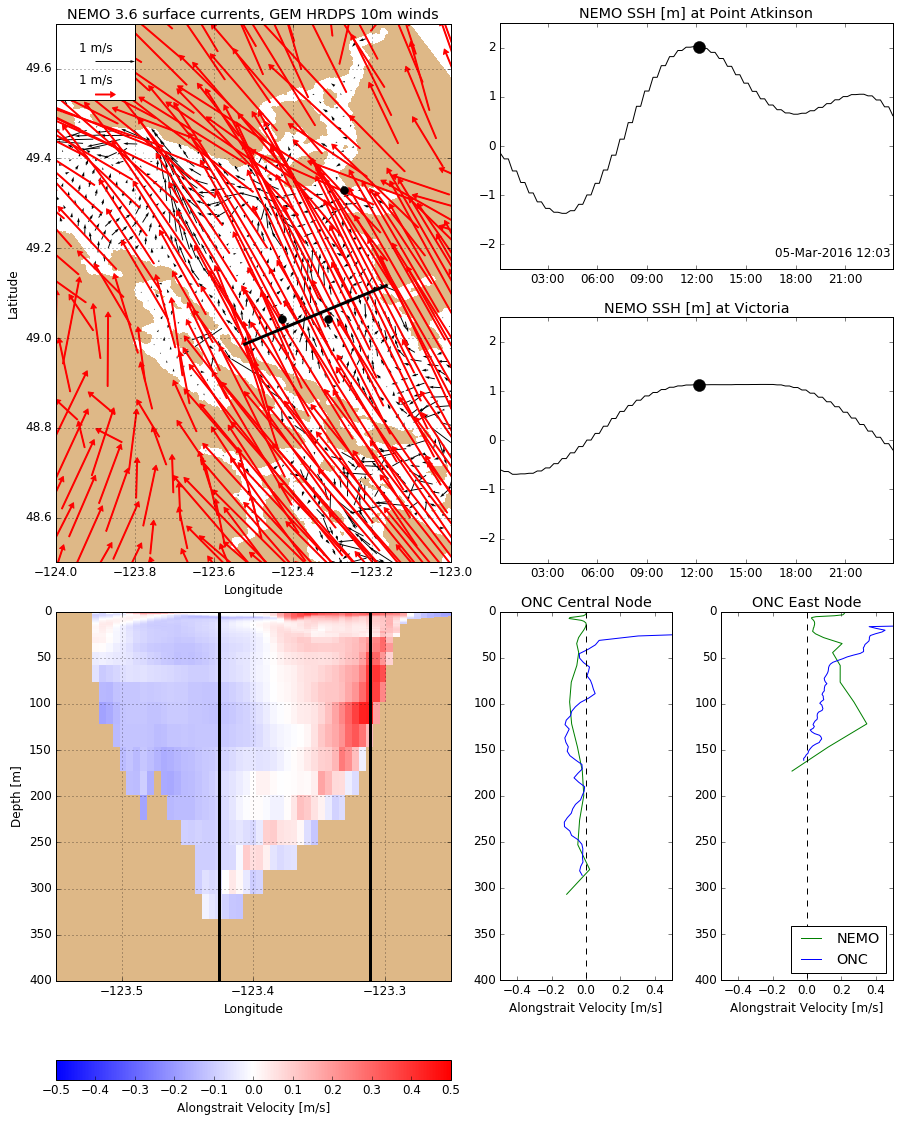

In [12]:
# Plotting parameters
# ------ T = 0 ----------
t             = [12]
zlevel        = [0]
ylocn         = 420
section_slice = np.arange(245, 315)
map_bounds    = np.array([-124, -123, 48.5, 49.7])

# Make Plots
make_plots('2016-mar-05', t=t, zlevel=zlevel, ylocn=ylocn, section_slice=section_slice, map_bounds=map_bounds)

#plt.savefig('NEMO_currents.eps', bbox_inches='tight')